# SAR Image Colorization


## Import Libraries


In [1]:
import numpy as np
import pystac_client
from tqdm import tqdm
import tensorflow as tf
import planetary_computer
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Huber
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from Utilities.utils import get_data, build_and_split_images, process_and_save_images, postprocess_tens

## Utility Functions


In [2]:
def get_data(catalog, bbox, time):
    search = catalog.search(
        collections=["sentinel-1-grd"],
        bbox=bbox,
        datetime=time,
    )
    items = search.item_collection()
    return items


def build_and_split_images(items, patch_size=(256, 256)):
    def build_image(item):
        if "vv" in item.assets:
            vv = (
                rioxarray.open_rasterio(
                    item.assets["vv"].href, overview_level=2)
                .astype(float)
                .squeeze()
            )
        else:
            vv = xr.DataArray(np.zeros(patch_size, dtype=float))

        if "vh" in item.assets:
            vh = (
                rioxarray.open_rasterio(
                    item.assets["vh"].href, overview_level=2)
                .astype(float)
                .squeeze()
            )
        else:
            vh = xr.DataArray(np.zeros(patch_size, dtype=float))

        r = vv / 600
        g = vh / 270
        b = (vv / vh).where(vh > 0) / 9

        data = xr.concat([r, g, b], dim="band").clip(
            0, 1).where(lambda x: x > 0)

        if "sat:orbit_state" in item.properties and item.properties["sat:orbit_state"].lower() == "descending":
            data = np.flip(data, axis=(1, 2)).clip(0, 1)

        data = data.fillna(0)
        data = np.nan_to_num(data, nan=0.0, posinf=1.0, neginf=0.0)
        image = (data).astype(np.float32).transpose(1, 2, 0)

        return image

    all_patches = []

    try:
        for item in tqdm(items):
            asset = item.assets.get('thumbnail')
            image_url = asset.href

            with rasterio.open(image_url) as src:
                image = src.read()

            h, w = image.shape[:2]
            patch_h, patch_w = patch_size

            built_image = build_image(item)

            for i in range(0, h, patch_h):
                for j in range(0, w, patch_w):
                    patch = built_image[i:i + patch_h, j:j + patch_w, :]
                    all_patches.append(patch)
        return all_patches
    except Exception as e:
        print(e)
        return None

def process_and_save_images(data,index,X_dim=256, Y_dim=256):
    filtered_data = []
    for i in range(len(data) - 1, -1, -1): 
        try:
            if data[i].shape != (X_dim, Y_dim, 3):
                data.pop(i)  
                print(f'Popped {i} from the list due to incorrect shape.')
            else:
                filtered_data.append(data[i])
        except AttributeError:  
            data.pop(i)
            print(f'Popped {i} due to invalid data.')

    lab_images = [color.rgb2lab(image) for image in filtered_data if image is not None and image.shape[-1] == 3]
    lab_images = np.array(lab_images)

    return lab_images

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
    # tens_orig_l 	1 x 1 x H_orig x W_orig
    # out_ab 		1 x 2 x H x W

    HW_orig = tf.shape(tens_orig_l)[2:]
    HW = tf.shape(out_ab)[2:]

    # Resize if necessary
    if HW_orig[0] != HW[0] or HW_orig[1] != HW[1]:
        out_ab_orig = tf.image.resize(out_ab, size=HW_orig, method=mode)
    else:
        out_ab_orig = out_ab

    # Concatenate L and ab channels to form LAB image
    out_lab_orig = tf.concat([tens_orig_l, out_ab_orig], axis=1)

    # Convert LAB to RGB
    out_lab_orig_np = out_lab_orig.numpy()
    out_rgb = color.lab2rgb(out_lab_orig_np[0, ...].transpose((1, 2, 0)))
    return out_rgb

# take B&W image and predict color
def preprocess_image(image, model):
    image = tf.image.resize(image, (256, 256))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = color.rgb2lab(image)
    image_X = image[..., 0].reshape(1, 256, 256, 1) / 100
    image_Y = image[..., 1:].reshape(1, 256, 256, 2) / 128
    return image_X

## Retrieving Data


In [3]:
X_dim, Y_dim = 256, 256

In [4]:
# catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,
# )

In [5]:
# bbox_of_interest = [20, 15, 135, 70]
# time_of_interest = "2023-12-27/2023-12-31"
# items = get_data(catalog, bbox_of_interest, time_of_interest)
# print(f"Found {len(items)} items")

In [6]:
# data = []
# for i in range(0, len(items), 200):
#     data.append(build_and_split_images(items[i:i+200]))

## Saving & Loading the Data


To save time and computational resources, we will load the data from the file


In [7]:
# processed_data = []
# for i in range(len(data)):
#     processed_data.append(process_and_save_images(data[i],i))

# lab_images = np.concatenate(processed_data, axis=0)
# lab_images = lab_images.astype(np.float32)
# np.save('lab_images.npy', lab_images)

In [8]:
lab_images = np.load('Data/lab_images.npy')
lab_images.shape

(1159, 256, 256, 3)

## Splitting the LAB images into L and AB channels


In [9]:
X = lab_images[:, :, :, 0].reshape(-1, X_dim, Y_dim, 1) / 100

Y = lab_images[:, :, :, 1:] / 128

## Splitting the Data into Train Test Split


In [10]:
np.random.seed(69)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y)

## Building the Neural Network


In [11]:
early_stopping = EarlyStopping(
    patience=5,
    min_delta=1e-4
)

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(69)
tf.keras.backend.clear_session()
model = models.Sequential()

model.add(layers.Input(shape=(X_dim, X_dim, 1,)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Batch Normalization after Conv
model.add(layers.Conv2D(64, (3, 3), activation='relu',
          padding='same', strides=2))  # Downsample by 2
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu',
          padding='same', strides=2))  # Downsample by 2
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu',
          padding='same', strides=2))  # Downsample by 2
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())

# Deeper convolution layers
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(layers.Dense())
model.add(layers.BatchNormalization())

# Upsampling starts here
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Upsample by 2x
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Upsample by 2x
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Final upsampling to match input size
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Output layer: 2 channels for 'a' and 'b'
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.Dense(2))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0002),
              loss=Huber(), metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 128, 64)   │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64, 64, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32, 32, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       295,04

 Total params: 3,986,216 (15.21 MB)

 Trainable params: 3,982,440 (15.19 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Fitting Data on the Neural Network


In [13]:
# model.fit(XTrain, YTrain, epochs=20, batch_size=10,callbacks=[early_stopping])

## Saving the Model


In [14]:
# model.compile(optimizer=RMSprop(learning_rate=0.0002), loss=Huber(reduction='sum_over_batch_size'), metrics=['accuracy'])
# model.save('my_model.h5')

## Loading the Model


In [15]:
# Load the model without compiling
loaded_model = tf.keras.models.load_model('Model/my_model.h5', compile=False)

# Recompile the model with valid loss and reduction
loaded_model.compile(optimizer='RMSprop',
                     loss=Huber(reduction='sum_over_batch_size'),
                     metrics=['accuracy'])

## Evaluating the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


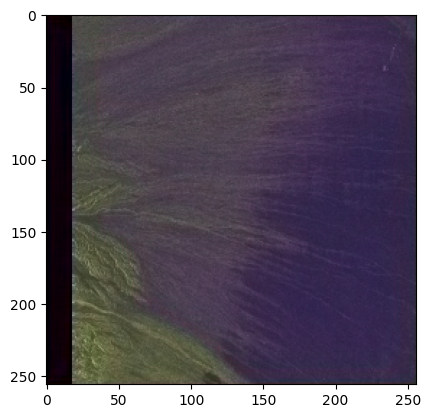

RGB Min: 0.0, RGB Max: 0.6893061995506287
Mean Squared Error (MSE) for image 69: 0.0801


In [16]:
image_no = 69

predicted_ab = loaded_model.predict(
    XTest[image_no].reshape(-1, X_dim, Y_dim, 1))

# Preprocessing step (assuming L channel is in the range [0, 1])
tens_orig_l = tf.convert_to_tensor(XTest[image_no].reshape(
    # L channel scaled to [0, 100]
    1, 1, X_dim, Y_dim) * 100, dtype=tf.float32)

# Convert predicted_ab to TensorFlow Tensor and scale it back to [-128, 128]
out_ab = tf.convert_to_tensor(predicted_ab, dtype=tf.float32)
out_ab = tf.transpose(out_ab, perm=[0, 3, 1, 2])  # Reshape from NHWC to NCHW
out_ab = out_ab * 128  # Scale the predicted ab channels

# Assuming postprocess_tens is a function that converts L and ab channels to RGB
predicted_rgb = postprocess_tens(tens_orig_l, out_ab)

# Visualize the image
plt.imshow(predicted_rgb)
plt.axis('off')
plt.show()

# Check the range of the predicted RGB image
print(f"RGB Min: {tf.reduce_min(predicted_rgb).numpy()}, RGB Max: {
      tf.reduce_max(predicted_rgb).numpy()}")
mse = np.mean((YTest[image_no] - predicted_ab) ** 2)
print(f"Mean Squared Error (MSE) for image {image_no}: {mse:.4f}")

In [17]:
loaded_model.evaluate(XTest, YTest)

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7963 - loss: 0.0049


[0.004990137182176113, 0.8021747469902039]